In [1]:
# Guoqiang Tang
# Evaluate by reading metrics from statistical metrics
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, entry)) for entry in os.listdir(directory))


# Load Metrics

In [2]:
basins = []
for i in range(627):
    basins.append(f'level1_{i}')

In [3]:
# infiles
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err'
infilelist_stat = [f'{inpath}/{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt' for i in basins]
print('The number of stat files:', len(infilelist_stat))

infilelist_ostmodel = [f'{inpath}/{i}_OSTRICHcalib/archive/PreserveBestModel/OstModel0.txt' for i in basins]
print('The number of OstModel0.txt files:', len(infilelist_stat))

infilelist_ostmodel_all = [f'{inpath}/{i}_OSTRICHcalib/run/OstModel0.txt' for i in basins]
print('The number of OstModel0.txt files:', len(infilelist_ostmodel_all))

The number of stat files: 627
The number of OstModel0.txt files: 627
The number of OstModel0.txt files: 627


In [4]:
# Metrics from OstModel0.txt
num = len(infilelist_ostmodel)
meanerr_ost = np.nan * np.zeros([num, 2]) # default param kge and best param kge

for i in range(num):
    infile_OstModel = infilelist_ostmodel[i]

    if os.path.isfile(infile_OstModel):
        df_OstModel = pd.read_csv(infile_OstModel, delim_whitespace=True)
        df_OstModel['obj.function'] = df_OstModel['obj.function'].values.astype(float) # some times there is NaN string
        meanerr_ost[i, 0] = df_OstModel['obj.function'].values[0]
        meanerr_ost[i, 1] = df_OstModel['obj.function'].values[-1]

In [5]:
# Metrics from OstModel0.txt, all outputs
num = len(infilelist_ostmodel)
meanerr_ost = np.nan * np.zeros([num, 2]) # default param kge and best param kge
meanerr_ost_all = []

for i in range(num):
    infile_OstModel = infilelist_ostmodel_all[i]

    if os.path.isfile(infile_OstModel):
        df_OstModel = pd.read_csv(infile_OstModel, delim_whitespace=True)
        df_OstModel['obj.function'] = df_OstModel['obj.function'].values.astype(float) # some times there is NaN string
        meanerr_ost_all.append(df_OstModel['obj.function'].values)

In [6]:
# Metrics from trial_stats_allrecords.txt

def read_trial_stats_allrecords(file_path):
    kge_values = []
    rmse_values = []
    mae_values = []
    maxmerr_values = []

    with open(file_path, 'r') as file:
        for line in file:
            if '#streamflow_KGE' in line:
                kge_value = float(line.split('#')[0].strip())
                kge_values.append(kge_value)
            elif '#streamflow_RMSE' in line:
                rmse_value = float(line.split('#')[0].strip())
                rmse_values.append(rmse_value)
            elif '#streamflow_abserr' in line:
                v = float(line.split('#')[0].strip())
                mae_values.append(v)
            elif '#streamflow_maxmontherr' in line:
                v = float(line.split('#')[0].strip())
                maxmerr_values.append(v)

    return np.array(kge_values), np.array(rmse_values), np.array(mae_values), np.array(maxmerr_values)

num = len(infilelist_ostmodel)
kge_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
rmse_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
mae_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
maxmerr_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge

for i in range(num):
    infile_stat = infilelist_stat[i]

    if os.path.isfile(infile_stat):

        try:
            tmpkge, tmprmse, tmpmae, tmpmaxmerr = read_trial_stats_allrecords(infile_stat)
            
            kge_stat[i, 0] = tmpkge[0]
            kge_stat[i, 1] = tmpkge[-1]
            
            rmse_stat[i, 0] = tmprmse[0]
            rmse_stat[i, 1] = tmprmse[-1]
        
            mae_stat[i, 0] = tmpmae[0]
            mae_stat[i, 1] = tmpmae[-1]
        
            maxmerr_stat[i, 0] = tmpmaxmerr[0]
            maxmerr_stat[i, 1] = tmpmaxmerr[-1]

        except:
            print('wrong')

# Load basin information

In [7]:
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)
df_info.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,Source,...,RawTDXarea,HSTDXarea,MHTDXarea,RawCAMELSbias,RawTDXbias,HSTDXbias,MHTDXbias,final_bias,geometry,file_obsQ
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,NaN,NaN,647993,RawTDX,...,2246.946668,2246.628415,2246.132802,0.022767,-0.002554,-0.002695,-0.002915,0.002554,POLYGON ((-68.84000529335947 46.73746031546882...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,NaN,NaN,312624,HSTDX,...,615.173865,586.427404,586.602450,0.081568,0.072479,0.022363,0.022668,0.022363,POLYGON ((-68.13005554673525 44.64716666195261...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,NaN,NaN,662248,RawCAMELS,...,3654.475429,3653.788946,3653.845830,-0.000004,-0.005901,-0.006088,-0.006073,0.000004,POLYGON ((-68.35800170861474 45.67902755716805...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,NaN,NaN,309614,RawCAMELS,...,775.632787,772.001421,772.168545,-0.003258,0.008560,0.003838,0.004055,0.003258,POLYGON ((-69.67646789509475 45.14558029212971...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,NaN,NaN,310157,RawCAMELS,...,914.491471,914.237495,913.814091,-0.004558,0.005931,0.005651,0.005185,0.004558,POLYGON ((-70.10847473135688 45.21669387774366...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...


# Changing curve of obj funcs

In [8]:
def improve_against_previous_runs(data):
    flag = np.zeros(len(data))
    mag = np.zeros(len(data))
    for i in range(1, len(data)):
        if data[i]<np.nanmin(data[:i]):
            flag[i] = 1
            mag[i] = (data[i] - np.nanmin(data[:i])) / np.nanmin(data[:i])
    return flag, mag

max_length = max(len(errors) for errors in meanerr_ost_all)
meanerr_ost_all2 = np.full((len(meanerr_ost_all), max_length), np.nan)
improveflag = np.full((len(meanerr_ost_all), max_length), np.nan)
improveflag_mag = np.full((len(meanerr_ost_all), max_length), np.nan)
lastimprovpos = np.full(len(meanerr_ost_all), np.nan)
lastimprovmag = np.full(len(meanerr_ost_all), np.nan)

for i, errors in enumerate(meanerr_ost_all):
    meanerr_ost_all2[i, :len(errors)] = errors
    improveflag[i, :len(errors)], improveflag_mag[i, :len(errors)] = improve_against_previous_runs(errors)
    lastimprovpos[i] = np.where(improveflag[i, :len(errors)])[0][-1] / len(errors)
    dtmp = improveflag_mag[i, :len(errors)]
    lastimprovmag[i] = dtmp[dtmp!=0][-1]

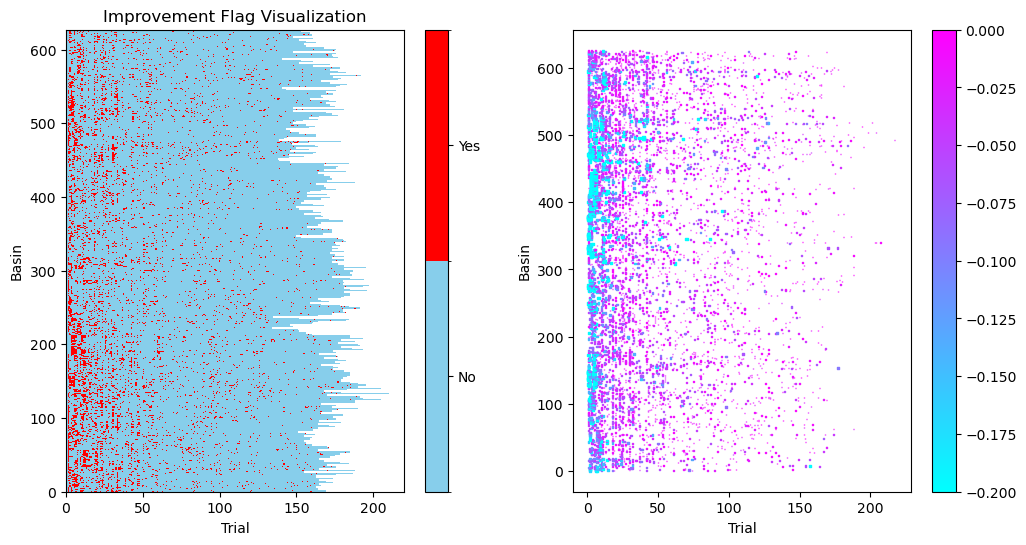

In [10]:


fig = plt.figure(figsize=(12, 6))  # Adjust the width here (width, height)


fig.add_subplot(1,2,1)

# Create a colormap with specific colors for 0 and 1
colors = ['skyblue', 'red']  # Blue for 0, Red for 1

# Create a ListedColormap
cmap = mcolors.ListedColormap(colors)

# Define the bounds for the colormap
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Mask NaN values
masked_array = np.ma.masked_where(np.isnan(improveflag), improveflag)

# Plot using imshow with adjusted figure size and aspect ratio
cax = plt.imshow(masked_array, cmap=cmap, norm=norm, aspect='auto', extent=[0, improveflag.shape[1], 0, improveflag.shape[0]])

# Create a colorbar with appropriate labels, excluding NaN
cbar = plt.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['No', 'Yes'])

plt.ylabel('Basin')
plt.xlabel('Trial')
plt.title('Improvement Flag Visualization')

fig.add_subplot(1,2,2)
dplot = improveflag_mag.copy()
dplot[dplot==0] = np.nan
# plt.imshow(dplot, cmap='jet')
# plt.colorbar()

# Create a grid of coordinates
x, y = np.meshgrid(range(dplot.shape[1]), range(dplot.shape[0]))

# Mask the nan values
mask = ~np.isnan(dplot)

# Create a scatter plot
plt.scatter(x[mask], y[mask], c=dplot[mask], cmap='cool', marker='s', s=np.abs(dplot[mask])*10, vmin=-0.2, vmax=0)  # Adjust 's' for marker size as needed
plt.colorbar()
plt.ylabel('Basin')
plt.xlabel('Trial')

plt.show()

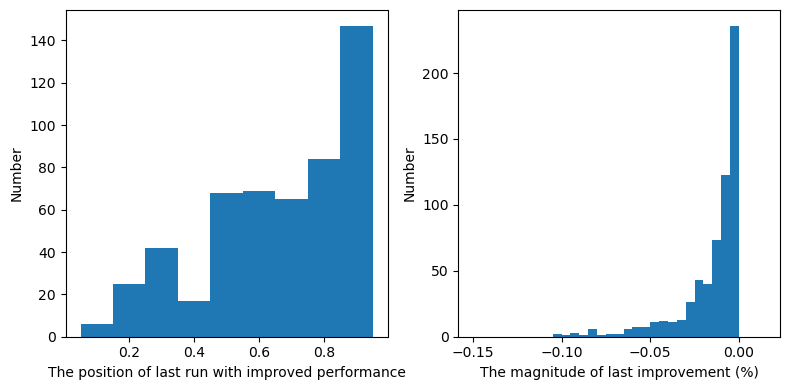

In [18]:

fig = plt.figure(figsize=[8, 4])

fig.add_subplot(1,2,1)
plt.hist(lastimprovpos, np.arange(0.05, 1.05, 0.1))
plt.xlabel('The position of last run with improved performance')
plt.ylabel('Number')


fig.add_subplot(1,2,2)
plt.hist(lastimprovmag, np.arange(-0.15, 0.02, 0.005))
plt.xlabel('The magnitude of last improvement (%)')
plt.ylabel('Number')

plt.tight_layout()
plt.show()

In [29]:
# for each basin
# extract the 5 best metrics and see whether they have a notable change

n = 5
metric_bestn = np.nan * np.zeros([len(meanerr_ost_all), n])
for i in range(len(meanerr_ost_all)):
    di = np.sort(meanerr_ost_all[i])
    metric_bestn[i, :] = di[:n][::-1] # smallest error and ranked


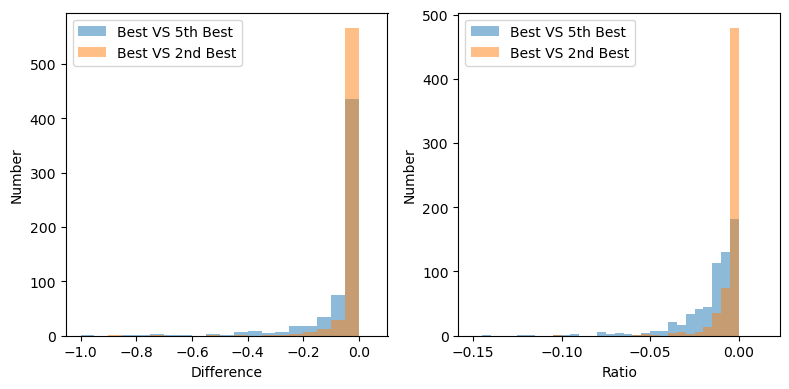

In [49]:

fig = plt.figure(figsize=[8, 4])

fig.add_subplot(1,2,1)
diff = metric_bestn[:,-1] - metric_bestn[:,0]
plt.hist(diff, np.arange(-1, 0.1, 0.05), alpha=0.5, label='Best VS 5th Best')

diff = metric_bestn[:,-1] - metric_bestn[:,-2]
plt.hist(diff, np.arange(-1, 0.1, 0.05), alpha=0.5, label='Best VS 2nd Best')

plt.xlabel('Difference')
plt.ylabel('Number')
plt.legend()

fig.add_subplot(1,2,2)

diff = (metric_bestn[:,-1] - metric_bestn[:,0])/metric_bestn[:,-1]
plt.hist(diff, np.arange(-0.15, 0.02, 0.005), alpha=0.5, label='Best VS 5th Best')

diff = (metric_bestn[:,-1] - metric_bestn[:,-2])/metric_bestn[:,-1]
plt.hist(diff, np.arange(-0.15, 0.02, 0.005), alpha=0.5, label='Best VS 2nd Best')

plt.xlabel('Ratio')
plt.ylabel('Number')
plt.legend()


plt.tight_layout()
plt.show()

# Plot

In [50]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

## Plot iteration number

In [52]:
trialnum = [len(i) for i in meanerr_ost_all]
trialnum = np.array(trialnum)
print(np.nanmean(trialnum))

175.8213716108453


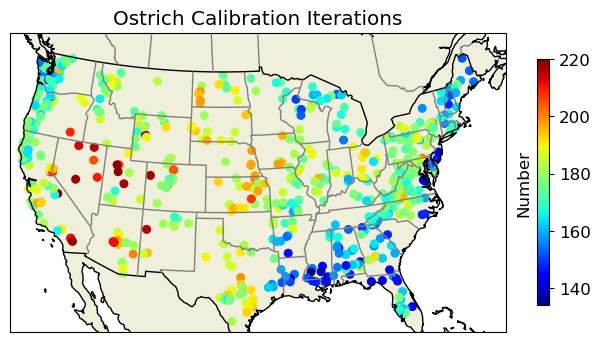

In [53]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8, 4])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(1, 1, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(df_info['lon_cen'].values, df_info['lat_cen'].values, 30, trialnum, cmap='jet', transform=transf)
ax.set_title('Ostrich Calibration Iterations')
    
cax = plt.colorbar(p, ax=ax, label='Number', location='right', shrink=0.8)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')

# plt.savefig('Ostrich_iter_num.png', dpi=600, bbox_inches='tight', pad_inches=0)

## KGE map

In [54]:
print('defa / cali kge', np.nanmean(kge_stat,axis=0))
print('defa / cali kge', np.nanmedian(kge_stat,axis=0))

defa / cali kge [-1.21288644  0.2654586 ]
defa / cali kge [0.195203 0.375364]


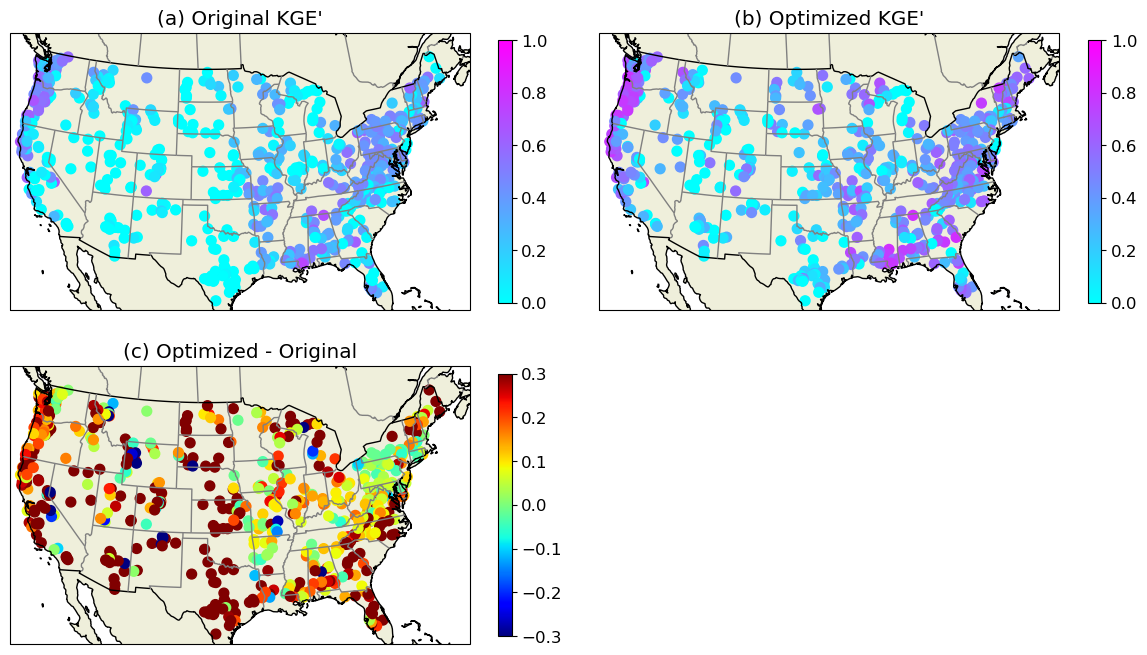

In [55]:
data = [kge_stat[:,0], kge_stat[:,1], kge_stat[:,1]-kge_stat[:,0]]
title = ["(a) Original KGE'", "(b) Optimized KGE'", "(c) Optimized - Original", "(d) Optimized - Original",]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0, 1], [0, 1], [-0.3, 0.3]]


font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(df_info['lon_cen'].values, df_info['lat_cen'].values, 50, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
# plt.savefig('CAMELS_calib_kge.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

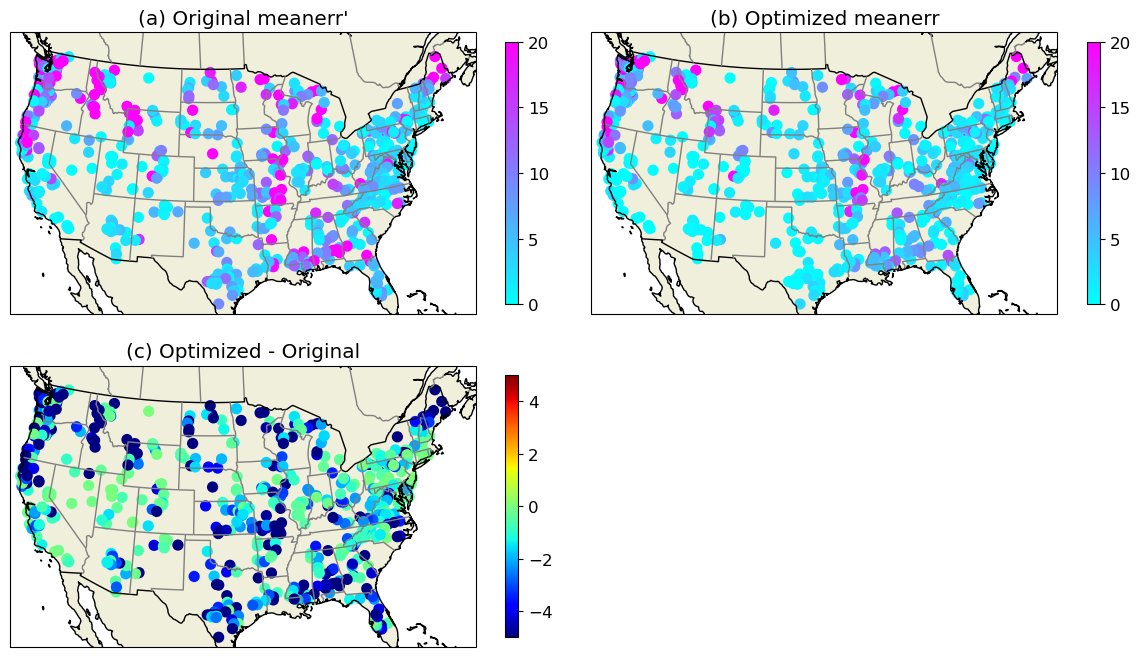

In [56]:
d1 = (maxmerr_stat[:,0]+mae_stat[:,0])/2
d2 = (maxmerr_stat[:,1]+mae_stat[:,1])/2
data = [d1, d2, d2-d1]
title = ["(a) Original meanerr'", "(b) Optimized meanerr", "(c) Optimized - Original", "(d) Optimized - Original",]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0, 20], [0, 20], [-5, 5]]


font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(df_info['lon_cen'].values, df_info['lat_cen'].values, 50, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
# plt.savefig('CAMELS_calib_kge.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

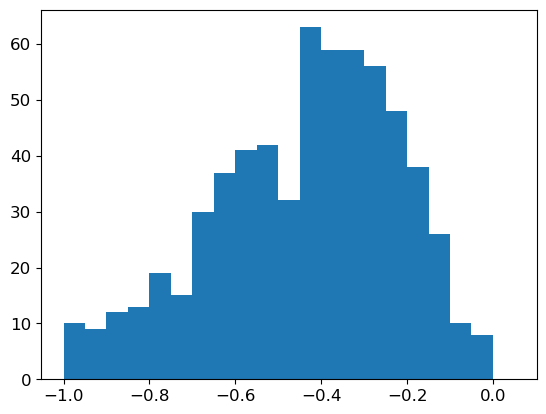

In [57]:
plt.hist( (d2-d1)/d1, np.arange(-1, 0.1, 0.05))
plt.show()

In [61]:
d1 = (maxmerr_stat[:,0]+mae_stat[:,0])/2
d2 = (maxmerr_stat[:,1]+mae_stat[:,1])/2
print('meanerr default', np.nanmean(d1), np.nanmedian(d1))
print('meanerr calibrated', np.nanmean(d2), np.nanmedian(d2))
print(np.sum(d1>d2)/len(d1))


meanerr default 9.257844082137161 4.0402675
meanerr calibrated 5.018025055821371 2.084395
1.0


In [64]:
print('defa maxmerr / mae', np.nanmean(maxmerr_stat[:,0]), np.nanmean(mae_stat[:,0]))
print('calib maxmerr / mae', np.nanmean(maxmerr_stat[:,1]), np.nanmean(mae_stat[:,1]))

print('#######')
print('defa maxmerr / mae', np.nanmedian(maxmerr_stat[:,0]), np.nanmedian(mae_stat[:,0]))
print('calib maxmerr / mae', np.nanmedian(maxmerr_stat[:,1]), np.nanmedian(mae_stat[:,1]))

defa maxmerr / mae 10.516845480063797 7.998842684210527
calib maxmerr / mae 4.380194370015949 5.6558557416267945
#######
defa maxmerr / mae 4.214037 3.859353
calib maxmerr / mae 1.562293 2.583847


# Plot runoff curve of a selected basin

In [71]:
b = 97
files_defa = glob.glob(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err/level1_{b}_OSTRICHcalib/archive/PreserveModelOutput/Run_0/*.h0*.nc')
files_defa.sort()

files_calib = glob.glob(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err/level1_{b}_OSTRICHcalib/archive/PreserveBestModel/*.h0*.nc')
files_calib.sort()


In [72]:
df_obs = pd.read_csv("/glade/work/guoqiang/CTSM_CAMELS/CAMLES_Qobs/02056900_streamflow_qc.txt", delim_whitespace=True,header=None)
df_obs

,0,1,2,3,4,5
0,2056900,1980,1,1,106.0,A
1,2056900,1980,1,2,106.0,A
2,2056900,1980,1,3,105.0,A
3,2056900,1980,1,4,105.0,A
4,2056900,1980,1,5,114.0,A
...,...,...,...,...,...,...
12779,2056900,2014,12,27,-999.0,M
12780,2056900,2014,12,28,-999.0,M
12781,2056900,2014,12,29,-999.0,M
12782,2056900,2014,12,30,-999.0,M


In [73]:
ds_defa = xr.open_mfdataset(files_defa)
ds_calib = xr.open_mfdataset(files_calib)

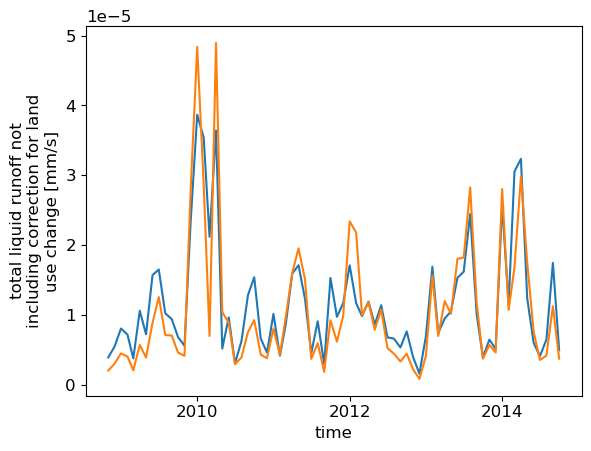

In [74]:
ds_defa.QRUNOFF.isel(lndgrid=0).plot()
ds_calib.QRUNOFF.isel(lndgrid=0).plot()

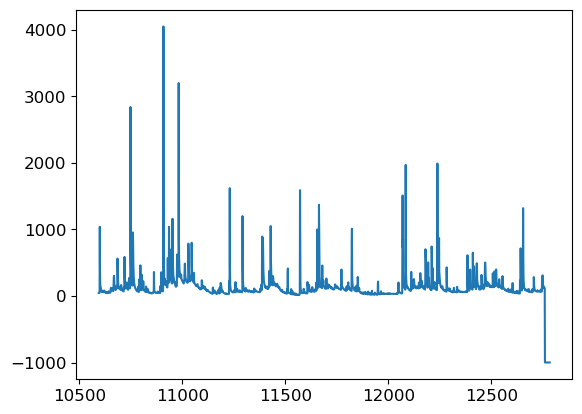

In [77]:
plt.plot(df_obs[-2190:][4])